# Beam Simulations
Getting started with notes from James Lamb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft

import astropy.units as u
from astropy import constants as const

## Start with 1.35 GHz, ideal beam.

### Note on various sizes
EXTENT_M is the extent of the illumination pattern grid in meters. This controls the E beam spatial resolution.


In [2]:
coeffs = np.array([0.41014, 0.09540, -0.27752, 0.17076, -0.05474, 0.00988, -0.00095])

In [3]:
GRID_SIZE = 50 # for the dish part
DIAM = 5

ea_grid_m = np.meshgrid(np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1), np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1))
ea_grid = np.sum(np.power(np.sqrt(ea_grid_m[0][:-1, :-1]**2 + ea_grid_m[1][:-1, :-1]**2), np.arange(1, len(coeffs) + 1)[:,np.newaxis, np.newaxis]), axis=0)
aper_mask = ( np.sqrt(ea_grid_m[0][:-1,:-1]**2 + ea_grid_m[1][:-1, :-1]**2) < (5))
ea_grid[~aper_mask] = 0

# stick units in there
DIAM *= u.m
ea_grid_m *= u.m

/tmp/ipykernel_2964248/2004585610.py:4: RuntimeWarning: divide by zero encountered in log10
  p = ax.imshow(np.log10(ea_grid))


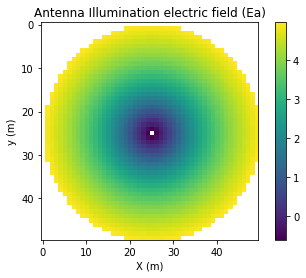

In [4]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect(1)
p = ax.imshow(np.log10(ea_grid))
ax.set_xlabel('X (m)')
ax.set_ylabel('y (m)')
ax.set_title('Antenna Illumination electric field (Ea)')
fig.colorbar(p)

Zero pad and then FFT

In [7]:
lm0, beam0 = to_beam(ea_grid, ea_grid_m, 1.35 * u.GHz , 250)

padded size is:  12500


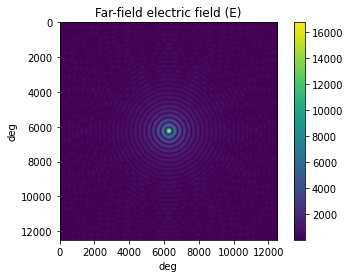

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
plt.imshow(np.abs(beam0))
ax.set_xlabel('deg')
ax.set_ylabel('deg')
ax.set_title('Far-field electric field (E)')
plt.colorbar()

In [357]:
lm0.shape

(2, 12500, 12500)

In [371]:
beam0[:, beam0.shape[0]//2].shape

(12500,)

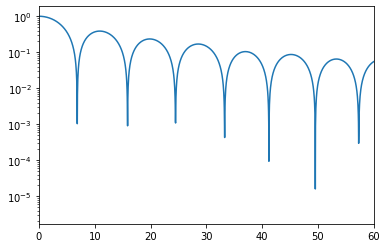

In [14]:
%matplotlib inline
plt.plot((lm0[1][beam0.shape[0]//2]).to(u.deg), np.abs(beam0[:, beam0.shape[0]//2])/np.abs(beam0[:, beam0.shape[0]//2]).max())
plt.xlim([0,60])
plt.yscale('log')

In [354]:
%matplotlib widget
# the arctan gives the angle and avoids the 0-pi confusion.
plt.imshow(np.arctan((beam0.imag/beam0.real)))
plt.colorbar()
ax.set_xlabel('deg')
ax.set_ylabel('deg')
ax.set_title('Far-field electric field (E)')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 1.0, 'Far-field electric field (E)')

## All the extra phase stuff
For everything else, I should be able to imprint an extra phase $\theta(x,y)=\Delta p(x,y)$ on the illumination pattern, and then FT.

#### Surface error

# Fitting the power beam

In [16]:
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [26]:
data = amp[d1][:,d2][450:550, 450:550] ** 2

In [27]:
params = fitgaussian(data)

In [28]:
params

array([3.76035193e+11, 4.99989148e+01, 4.99989148e+01, 1.37405372e+01,
       1.37405372e+01])

In [29]:
amp.shape

(1000, 1000)

In [34]:
%matplotlib widget
fit = gaussian(*params)
plt.imshow(data)
plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [31]:
params[3] * freqs[1] * 57.2958

2.198486737514539

In [35]:
data.shape

(100, 100)

In [41]:
%matplotlib widget
plt.plot(np.linspace(-50, 50, 100) * freqs[1] * 57.2958, data[data.shape[0]//2,:]/data[data.shape[0]//2,:].max())
plt.grid()
plt.xlabel('deg')
plt.ylabel('Normalized Power')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Normalized Power')

# Surface deformation with Zernike polynomials
Dave said that the Knoll #4 mode (m=0, n=2) contributes to 80% of the rms, so I'll just start with simulating that.

We know that the wavefront variance $\sigma^2$ is given by sum of all the coefficients squared.

Let's do $\Delta p = C r^2cos(2\theta)$ for (m=0, n=2). and C=1mm.

Lemme work through one example and plot some stuff first.

In [66]:
import astropy.units as u
from astropy import constants as const

In [261]:
GRID_SIZE = 50 # for the dish part
DIAM = 5 * u.m

aper_xy = np.meshgrid(np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1), np.linspace(-DIAM, DIAM, num=GRID_SIZE + 1))
aper_r = np.sqrt(aper_xy[0]**2 + aper_xy[1]**2)
aper_mask = (aper_r < (5 * u.m))
# Knoll 4
delta_p = (2 * ((aper_xy[0]/DIAM)**2 + (aper_xy[1]/DIAM)**2) - 1)
delta_p[~aper_mask] = 0
norm = np.sqrt(np.mean(delta_p[aper_mask]**2))
# scale it so that I get rms = 1 mm
delta_p *=  1 * u.mm/ norm

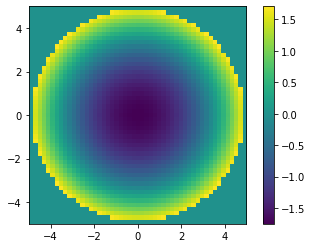

In [262]:
plt.imshow(delta_p, extent=[-DIAM_M, DIAM_M, -DIAM_M, DIAM_M])
plt.colorbar()

In [263]:
np.max(delta_p)

<Quantity 1.70702808 mm>

In [233]:
np.sqrt(np.mean(delta_p[aper_mask]**2))

<Quantity 1. mm>

Now turn this into phase (i.e. differential aperture field) for a single frequency.

In [234]:
f = 1.35 * u.GHz

I used a forward FFT to get the far-field pattern (i.e. e(-ikr) describing the wavefront) so I think this sign convention for extra path delay is probably correct.

In [235]:
aper_e = np.exp(-2j*np.pi*f*delta_p/const.c)

Text(0.5, 1.0, 'aperture field phase')

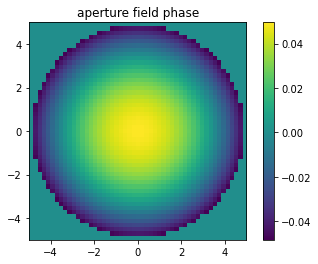

In [237]:
plt.imshow(np.angle(aper_e), extent=[-DIAM_M, DIAM_M, -DIAM_M, DIAM_M])
plt.colorbar()
plt.title('aperture field phase')

That was for visualization. For computing the actual beam I need only a very sparse sample of the aperture electric field.

In [305]:
GRID_SIZE = 50 # for the dish part
DIAM = 5 * u.m

def make_k4_aper_e(grid_size, rms, f):
    aper_xy = np.meshgrid(np.linspace(-DIAM, DIAM, num=grid_size), np.linspace(-DIAM, DIAM, num=grid_size))
    aper_r = np.sqrt(aper_xy[0]**2 + aper_xy[1]**2)
    aper_mask = (aper_r < DIAM)
    # Knoll 4
    delta_p = (2 * ((aper_xy[0]/DIAM)**2 + (aper_xy[1]/DIAM)**2) - 1)
    norm = np.sqrt(np.mean(delta_p[aper_mask]**2))
    # scale it so that I get rms = 1 mm
    delta_p *=  rms/ norm
    aper_e = np.exp(-2j*np.pi*f*delta_p/const.c)
    aper_e[~aper_mask] = 0
    return aper_xy, aper_e

In [306]:
aper_xy, aper_e = make_k4_aper_e(20, 1 * u.mm, 1.35 * u.GHz)

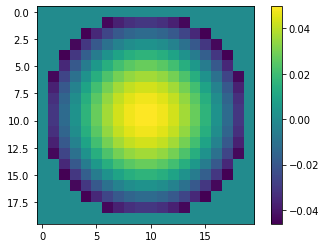

In [318]:
plt.imshow(np.angle(aper_e))
plt.colorbar()

In [291]:
np.sum(np.sqrt(aper_xy[0]**2 + aper_xy[1]**2) < 5 * u.m)

276

In [294]:
aper_xy[0].size

400

In [319]:
lm

<Quantity [[[-1.32553258, -1.32553258, -1.32553258, ..., -1.32553258,
             -1.32553258, -1.32553258],
            [-1.32500237, -1.32500237, -1.32500237, ..., -1.32500237,
             -1.32500237, -1.32500237],
            [-1.32447216, -1.32447216, -1.32447216, ..., -1.32447216,
             -1.32447216, -1.32447216],
            ...,
            [ 1.32394195,  1.32394195,  1.32394195, ...,  1.32394195,
              1.32394195,  1.32394195],
            [ 1.32447216,  1.32447216,  1.32447216, ...,  1.32447216,
              1.32447216,  1.32447216],
            [ 1.32500237,  1.32500237,  1.32500237, ...,  1.32500237,
              1.32500237,  1.32500237]],

           [[-1.32553258, -1.32500237, -1.32447216, ...,  1.32394195,
              1.32447216,  1.32500237],
            [-1.32553258, -1.32500237, -1.32447216, ...,  1.32394195,
              1.32447216,  1.32500237],
            [-1.32553258, -1.32500237, -1.32447216, ...,  1.32394195,
              1.32447216,  1.32

In [340]:
from scipy.special import jv
r = np.sqrt(lm[0]**2 + lm[1]**2) * 5 / (2 * 3e8/1.35e9)
ans = -1j * jv(3, r.value)/r.value

/tmp/ipykernel_3594329/3782194641.py:3: RuntimeWarning: invalid value encountered in true_divide
  ans = -1j * jv(3, r.value)/r.value


In [341]:
ans.real

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

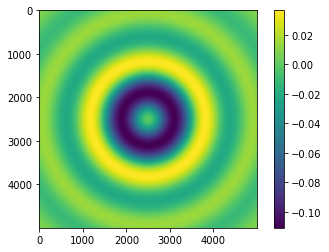

In [338]:
plt.imshow(ans.imag)
plt.colorbar()

In [6]:
# zero pad and FFT
def to_beam(illum, xy, f, pad_factor):
    # pad_factor gives how many over-sampled we want one resolution element to be
    pad_size = (illum.shape[0] // 2) * (pad_factor - 1)
    illum_padded = np.pad(illum, pad_size)
    print('padded size is: ', illum_padded.shape[0])
    beam = fft.fftshift(fft.fft2(illum_padded)) / illum.size # normalize to peak of 1
    dl = (((xy[0][0][1] - xy[0][0][0]) * f)/(2 * np.pi * const.c)).to(u.dimensionless_unscaled)
    l = fft.fftfreq(illum_padded.shape[0], d=dl)
    lm = fft.fftshift(np.meshgrid(l, l)) * u.radian
    return lm, beam

In [310]:
lm, beam = to_beam(aper_e, aper_xy, f, 250)

padded size is:  5000


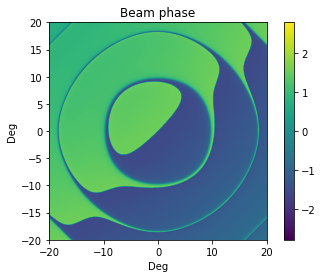

In [317]:
min_deg = lm[0].min().to(u.deg).value
max_deg = lm[0].max().to(u.deg).value
plt.imshow(np.angle(beam), extent=[min_deg, max_deg, min_deg, max_deg], vmin=-2.8, vmax=2.8)
#plt.imshow(np.arctan2(beam.imag, beam.real), extent=[min_deg, max_deg, min_deg, max_deg])
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.title('Beam phase')
plt.xlabel('Deg')
plt.ylabel('Deg')
plt.colorbar()

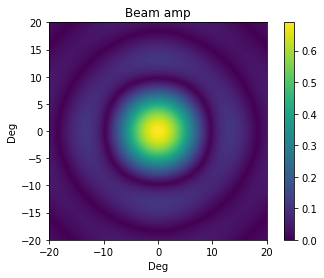

In [312]:
min_deg = lm[0].min().to(u.deg).value
max_deg = lm[0].max().to(u.deg).value
plt.imshow(np.abs(beam), extent=[min_deg, max_deg, min_deg, max_deg])
plt.title('Beam amp')
plt.xlabel('Deg')
plt.ylabel('Deg')
plt.xlim([-20, 20])
plt.ylim([-20, 20])
plt.colorbar()

Should the beam be rotationally symmetric?

# A quick experiment: take 2 * 1.7mm of extra path length for a source 10 deg away.

Calculate the per channel gain based on the frequency. And just simulate a snapshot.

Start by simulating a 8000 channel snapshot with configuration W>